In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    QuantileTransformer,
)

from src.config import DADOS_LIMPOS
from src.auxiliares import dataframe_coeficientes
from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)
from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
)

In [2]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room,population_per_room
0,-122.23,37.88,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591,0.365909
1,-122.22,37.86,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797,0.338217
2,-122.26,37.84,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294118,2.026891,0.260274,0.472016
3,-122.26,37.85,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679,0.622321
4,-122.26,37.84,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343675,2.362768,0.203216,0.442162


In [3]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 17515 entries, 0 to 17514
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17515 non-null  float64 
 1   latitude                  17515 non-null  float64 
 2   housing_median_age        17515 non-null  int8    
 3   total_rooms               17515 non-null  int16   
 4   total_bedrooms            17515 non-null  int16   
 5   population                17515 non-null  int16   
 6   households                17515 non-null  int16   
 7   median_income             17515 non-null  float64 
 8   median_house_value        17515 non-null  int32   
 9   ocean_proximity           17515 non-null  category
 10  median_income_cat         17515 non-null  int64   
 11  rooms_per_household       17515 non-null  float64 
 12  population_per_household  17515 non-null  float64 
 13  bedrooms_per_room         17515 non-null  float64 
 14  p

In [4]:
#Definir nossas colunas que serão preprocessadas
coluna_target = ['median_house_value']

coluna_one_hot_encoder = ['ocean_proximity']

coluna_ordinal_encoder = ['median_income_cat']

In [5]:
#Definir X e y
X = df.drop(columns = coluna_target)

y = df[coluna_target]

In [6]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room,population_per_room
0,-122.23,37.88,41,880,129,322,126,8.3252,NEAR BAY,5,6.984127,2.555556,0.146591,0.365909
1,-122.22,37.86,21,7099,1106,2401,1138,8.3014,NEAR BAY,5,6.238137,2.109842,0.155797,0.338217
2,-122.26,37.84,42,2555,665,1206,595,2.0804,NEAR BAY,2,4.294118,2.026891,0.260274,0.472016
3,-122.26,37.85,50,1120,283,697,264,2.1250,NEAR BAY,2,4.242424,2.640152,0.252679,0.622321
4,-122.26,37.84,50,2239,455,990,419,1.9911,NEAR BAY,2,5.343675,2.362768,0.203216,0.442162


In [7]:
y.head()

,median_house_value
0,452600
1,358500
2,226700
3,140000
4,158700


In [8]:
colunas_robust = df.columns.difference(coluna_target + coluna_one_hot_encoder + coluna_ordinal_encoder)
colunas_robust

Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
       'longitude', 'median_income', 'population', 'population_per_household',
       'population_per_room', 'rooms_per_household', 'total_bedrooms',
       'total_rooms'],
      dtype='str')

In [9]:
colunas_standard = ["longitude","latitude","housing_median_age"]

colunas_power = df.columns.difference(coluna_target + coluna_one_hot_encoder + coluna_ordinal_encoder + colunas_standard)
colunas_power

Index(['bedrooms_per_room', 'households', 'median_income', 'population',
       'population_per_household', 'population_per_room',
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='str')

In [37]:
#criar o preprocessamento

pipeline_robust = Pipeline(steps=[
    ("robust_sacaler", RobustScaler()),
    ("poly", PolynomialFeatures(degree=1, include_bias=False))
])

preprocessamento = ColumnTransformer(
    transformers = [
        ("one_hot_encoder", OneHotEncoder(drop='first'),coluna_one_hot_encoder),
        ("ordinal_encoder", OrdinalEncoder(categories='auto'),coluna_ordinal_encoder),
        ("robust_scaler_poly", pipeline_robust, colunas_robust),
    ],
)


In [12]:
param_grid = {
    "regressor__preprocessor__robust_scaler_poly__poly__degree": [1, 2, 3],
}

In [39]:
grid_search = grid_search_cv_regressor(
    regressor=LinearRegression(),
    param_grid=param_grid,
    preprocessor=preprocessamento,
    target_transformer=QuantileTransformer(output_distribution='normal'),
)

grid_search

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",TransformedTa...ion='normal'))
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'regressor__preprocesso...aler_poly__poly__degree': [1, 2, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.","['r2', 'neg_mean_absolute_error', ...]"
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",'neg_root_mean_squared_error'
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",KFold(n_split... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation 

In [40]:
grid_search.fit(X,y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",TransformedTa...ion='normal'))
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'regressor__preprocesso...aler_poly__poly__degree': [1, 2, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.","['r2', 'neg_mean_absolute_error', ...]"
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",'neg_root_mean_squared_error'
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",KFold(n_split... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation 

In [41]:
grid_search.best_params_

{'regressor__preprocessor__robust_scaler_poly__poly__degree': 3}

In [44]:
grid_search.best_score_

np.float64(-51251.83112378458)

In [42]:
grid_search.best_estimator_

,"regressor regressor: object, default=NoneRegressor object such as derived from:class:`~sklearn.base.RegressorMixin`. This regressor willautomatically be cloned each time prior to fitting. If `regressor isNone`, :class:`~sklearn.linear_model.LinearRegression` is created and used.",Pipeline(step...egression())])
,"transformer transformer: object, default=NoneEstimator object such as derived from:class:`~sklearn.base.TransformerMixin`. Cannot be set at the same timeas `func` and `inverse_func`. If `transformer is None` as well as`func` and `inverse_func`, the transformer will be an identitytransformer. Note that the transformer will be cloned during fitting.Also, the transformer is restricting `y` to be a numpy array.",QuantileTrans...tion='normal')
,"func func: function, default=NoneFunction to apply to `y` before passing to :meth:`fit`. Cannot be setat the same time as `transformer`. If `func is None`, the function used will bethe identity function. If `func` is set, `inverse_func` also needs to beprovided. The function needs to return a 2-dimensional array.",None
,"inverse_func inverse_func: function, default=NoneFunction to apply to the prediction of the regressor. Cannot be set atthe same time as `transformer`. The inverse function is used to returnpredictions to the same space of the original training labels. If`inverse_func` is set, `func` also needs to be provided. The inversefunction needs to return a 2-dimensional array.",None
,"check_inverse check_inverse: bool, default=TrueWhether to check that `transform` followed by `inverse_transform`or `func` followed by `inverse_func` leads to the original targets.",True
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('one_hot_encoder', ...), ('ordinal_encoder', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always ret

In [43]:
grid_search.best_estimator_.regressor_

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('reg', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('one_hot_encoder', ...), ('ordinal_encoder', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of th

In [20]:
# Definindo noss modelos de treino para comparação

regressors = {
    "DummyRegressor": {
        "preprocessor": None,
        "regressor": DummyRegressor(strategy="mean"),
        "target_transformer": None,
    },
    
    "LinearRegression": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": None,
    },
    "LinearRegression_target": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": QuantileTransformer(output_distribution='normal'),
    },
    
       "LinearRegression_grid_search": {
        "preprocessor": grid_search.best_estimator_.regressor_["preprocessor"],
        "regressor": grid_search.best_estimator_.regressor_["reg"],
        "target_transformer": grid_search.best_estimator_.transformer_,
    },
}

In [21]:
#Treinar e validar modelos

resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor)
    for nome_modelo, regressor in regressors.items()
}

resultados

{'DummyRegressor': {'fit_time': array([0.00638962, 0.00558662, 0.00792837, 0.00972128, 0.00893855]),
  'score_time': array([0.00850058, 0.01535559, 0.01171398, 0.01052761, 0.01178479]),
  'test_r2': array([-8.79886502e-04, -7.01292589e-05, -3.90446967e-04, -1.07273469e-04,
         -1.34175423e-04]),
  'test_neg_mean_absolute_error': array([-76256.6430076 , -76449.68322658, -76241.74334592, -77052.4072976 ,
         -77839.12138232]),
  'test_neg_root_mean_squared_error': array([-95147.59926567, -96287.73388159, -95461.5544825 , -96172.37627931,
         -97119.54792537])},
 'LinearRegression': {'fit_time': array([0.06279588, 0.05514979, 0.0713625 , 0.0503366 , 0.05837107]),
  'score_time': array([0.02450013, 0.02802277, 0.02008748, 0.02549839, 0.03117371]),
  'test_r2': array([0.69028914, 0.66606835, 0.66104148, 0.6679513 , 0.66398948]),
  'test_neg_mean_absolute_error': array([-39415.65518174, -40876.66288459, -41414.43293308, -40450.64599389,
         -41326.95514596]),
  'test_neg_

In [22]:
#dataframe comparativo com os resultados de tempo e erros dos modelos para cada 'cross-validation'
df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.00639,0.008501,-0.00088,-76256.643008,-95147.599266,0.01489
1,DummyRegressor,0.005587,0.015356,-0.00007,-76449.683227,-96287.733882,0.020942
2,DummyRegressor,0.007928,0.011714,-0.00039,-76241.743346,-95461.554483,0.019642
3,DummyRegressor,0.009721,0.010528,-0.000107,-77052.407298,-96172.376279,0.020249
4,DummyRegressor,0.008939,0.011785,-0.000134,-77839.121382,-97119.547925,0.020723
5,LinearRegression,0.062796,0.0245,0.690289,-39415.655182,-52927.949935,0.087296
6,LinearRegression,0.05515,0.028023,0.666068,-40876.662885,-55639.667647,0.083173
7,LinearRegression,0.071362,0.020087,0.661041,-41414.432933,-55567.007594,0.09145
8,LinearRegression,0.050337,0.025498,0.667951,-40450.645994,-55415.078057,0.075835
9,LinearRegression,0.058371,0.031174,0.663989,-41326.955146,-56292.942964,0.089545


In [25]:
#comparação das médias das métricas por modelo
df_resultados.groupby('model').mean().sort_values(by='test_neg_mean_absolute_error')

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.007713,0.011577,-0.000316,-76767.919652,-96037.762367,0.019289
LinearRegression,0.059603,0.025856,0.669868,-40696.870428,-55168.529239,0.08546
LinearRegression_target,0.079589,0.02505,0.679779,-38578.898399,-54328.598031,0.104638
LinearRegression_grid_search,0.676306,0.063658,0.714988,-35574.990041,-51250.099156,0.739964


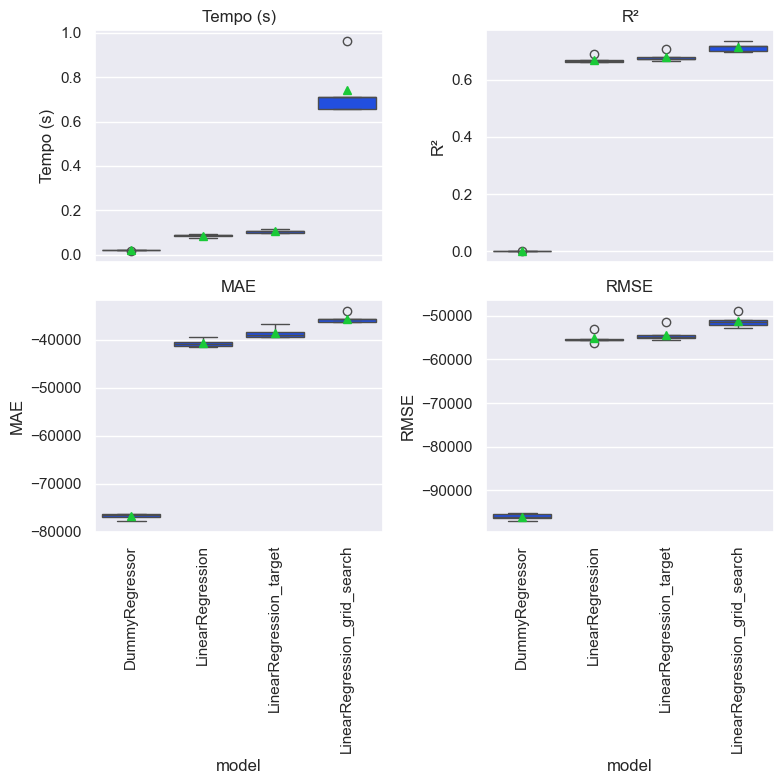

In [26]:
#gráfico comparativos das métricas de cada modelo
plot_comparar_metricas_modelos(df_resultados)

In [70]:
tempo_novo_anterior = df_resultados.groupby('model').mean()['time_seconds']['LinearRegression_grid_search'] / df_resultados.groupby('model').mean()['time_seconds']['LinearRegression_target']
print(f'tempo de processamento do modelo novo foi {tempo_novo_anterior:.0f}x maior que o modelo anterior')

tempo de processamento do modelo novo foi 7x maior que o modelo anterior


Adicionando um preprocessamento Polinomial de grau 3 em nossas colunas, obtivemos melhores resultado que o modelo anterior, porém o tempo de treinamento desse modelo foi 7x maior que o modelo anterior.

In [45]:
#coeficientes
grid_search.best_estimator_.regressor_['reg'].coef_[:,:5]

array([[-0.40882522, -0.20942144, -0.05674154, -0.02195089,  0.35313222]])

In [ ]:
#variáveis
#grid_search.best_estimator_.regressor_["preprocessor"].get_feature_names_out()

In [46]:
#criando dataframe dos coeficientes
coefs = dataframe_coeficientes(
    grid_search.best_estimator_.regressor_["reg"].coef_,
    grid_search.best_estimator_.regressor_["preprocessor"].get_feature_names_out()
)

coefs

,coeficiente
robust_scaler_poly__latitude longitude total_bedrooms,-6.391709
robust_scaler_poly__households longitude population_per_room,-5.392858
robust_scaler_poly__households latitude population_per_room,-5.196627
robust_scaler_poly__latitude longitude population_per_room,-4.864314
robust_scaler_poly__households^2 latitude,-3.622993
...,...
robust_scaler_poly__households latitude population,3.072256
robust_scaler_poly__latitude^2 total_rooms,3.098688
robust_scaler_poly__longitude population population_per_room,3.108012
robust_scaler_poly__households latitude total_bedrooms,4.162187


In [47]:
coefs[coefs['coeficiente'] == 0]

,coeficiente


In [50]:
coefs[coefs['coeficiente'].between(-3,3)]

,coeficiente
robust_scaler_poly__households population_per_room total_bedrooms,-2.930737
robust_scaler_poly__households^2 longitude,-2.732614
robust_scaler_poly__latitude population population_per_household,-2.654837
robust_scaler_poly__latitude^2 total_bedrooms,-2.617867
robust_scaler_poly__latitude population total_bedrooms,-2.594566
...,...
robust_scaler_poly__longitude population_per_household total_rooms,2.243811
robust_scaler_poly__longitude^2 total_rooms,2.503572
robust_scaler_poly__bedrooms_per_room latitude total_bedrooms,2.567266
robust_scaler_poly__bedrooms_per_room latitude longitude,2.652385


In [52]:
coefs = coefs[~coefs['coeficiente'].between(-3,3)]
coefs

,coeficiente
robust_scaler_poly__latitude longitude total_bedrooms,-6.391709
robust_scaler_poly__households longitude population_per_room,-5.392858
robust_scaler_poly__households latitude population_per_room,-5.196627
robust_scaler_poly__latitude longitude population_per_room,-4.864314
robust_scaler_poly__households^2 latitude,-3.622993
robust_scaler_poly__latitude longitude rooms_per_household,-3.465540
robust_scaler_poly__households latitude median_income,-3.255794
robust_scaler_poly__longitude^2 total_bedrooms,-3.184761
robust_scaler_poly__households total_bedrooms total_rooms,-3.101720
robust_scaler_poly__latitude population population_per_room,3.005683


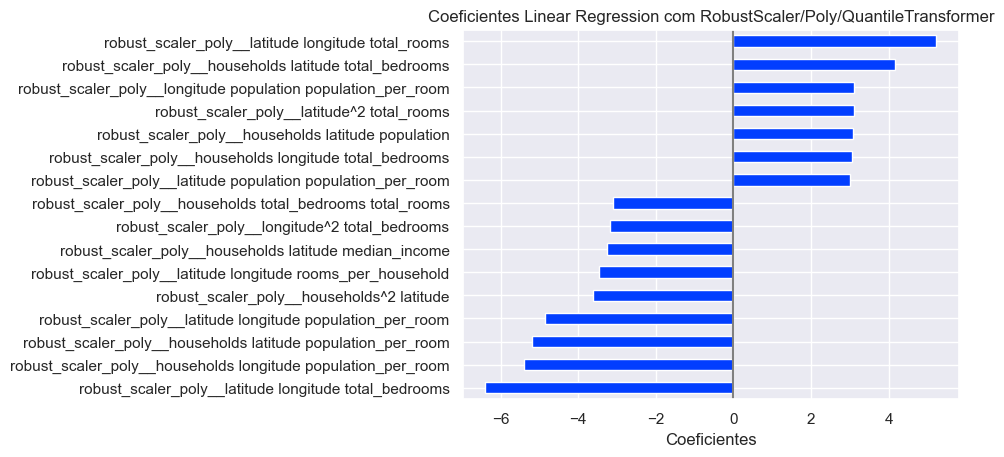

In [53]:
#analise gráfica dos coeficientes do melhor modelo
plot_coeficientes(
    coefs, 
    tituto="Coeficientes Linear Regression com RobustScaler/Poly/QuantileTransformer")

A adição do pré-processamento polinomial adicionou uma alta quantidade de coeficientes no modelo, aumentando a complexidade de compreensão do impacto das feaures em nosso target.

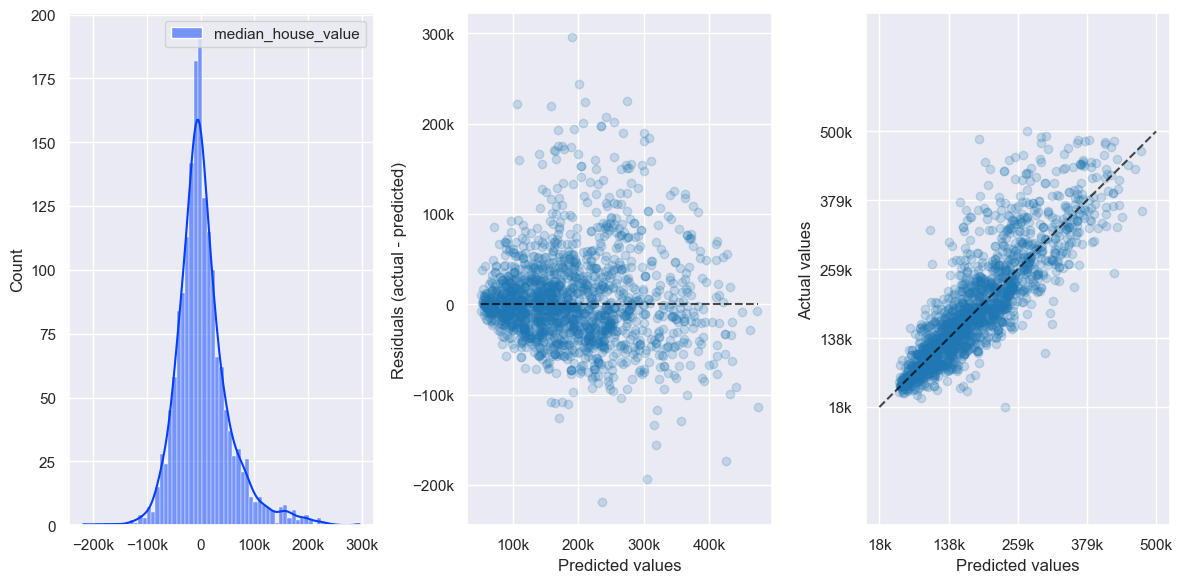

In [55]:
plot_residuos_estimador(
    grid_search.best_estimator_, 
    X, 
    y,
    fracao_amostra=0.1,
    eng_formatter=True
)

O grágico de resíduos mostra que o Modelo consegue prever os valores medios das casas com pequeno erro para a maior parte dos valores. E o modelo tem mais erros para uma valor menor que o valor real. Visualmente não há grande diferenças no residuos em relação ao modelos anterior, essa comparação pode ser melhor vizualiada na tabela e graficos comparativa de erros feita anteriormente.